### Training an object detector from scratch in PyTorch
#### Link: https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

In [1]:
import torch
import os

from torch.utils.data import Dataset

from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os



import mimetypes
import argparse
import imutils
import pickle

In [11]:
### Config ###

# path to the input dataset from which we derive the images and annotation files
BASE_PATH = "/home/irikos/Work/datasets/coco/"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images/train2017"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "labels/train2017"])

BASE_OUTPUT = "output"

# define the path to the output model, label encoder, plots output directory and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [12]:
### HYPERPARAMETERS ###

# determine the current device and based on that set the pin memory
# flag
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

# specify ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

# specify the loss weights
LABELS = 1.0
BBOX = 1.0

In [13]:
### CUSTOM TENSOR DATASET ###
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms
        
    def __getitem__(self, index):
        # grab the image, label and its bbox coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        
        # transpose the image such that its channel dimensions becomes the leading one
        # PyTorch requirements. Basically move from Height x Width x Channels to
        # Channels x Height x Width
        image = image.permute(2, 0, 1)
        
        # check to see if we have any image transformations to apply and, if so, apply them
        if self.transforms:
            image = self.transforms(image)
            
        # return a tuble of images, labels and bounding box coordinates
        return (image, label, bbox)
    
    def __len__(self):
        # return the size of the dataset
        return len(self.tensors[0])

In [14]:
### BBOX REGRESSOR ###
class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses):
        super(ObjectDetector, self).__init__()
        
        # initialize the base model and the number of classes
        self.baseModel = baseModel
        self.numClasses = numClasses
        
        # build the regressor head for outputting the bounding box coordinates
        self.regressor = Sequential(
            Linear(baseModel.fc.in_features, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 32),
            ReLU(),
            Linear(32, 4),
            Sigmoid()
        )
        
        # build the classifier head to predict the class labels
        self.classifier = Sequential(
            Linear(baseModel.fc.in_features, 512),
            ReLU(),
            Dropout(),
            Linear(512, 512),
            ReLU(),
            Dropout(),
            Linear(512, self.numClasses)
        )
    
        # set the classifier of our base model to produce outputs from the last convolution block
        self.baseModel.fc = Identity()
        
    def forward(self, X):
        # pass the inputs through the base model and then obtain predictions
        # from two different branches of the network
        features = self.baseModel(X)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)
        
        # return the outputs as a tuple
        return (bboxes, classLogits)
    
    

In [22]:
### TRAINING ###

# initialize the list of data (images), class labels, target bounding box coordinates and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".txt")):
    rows = open(csvPath).read().strip().split("\n")
    # loop over the rows
    for row in rows:
        # break fow into filename, bbox coords and class label
        print(row)
        row = row.split(" ")
        if (len(row) > 1): 
            print(row)
            (label, startX, startY, endX, endY) = row
            filename = csvPath.split("/")[-1].split('.')[-2]
            # derive the path to the input image, load the image (in openCV format) and grab its dimensions
            imagePath = os.path.sep.join([IMAGES_PATH, filename]) + ".jpg"

            print(imagePath)
            image = cv2.imread(imagePath)
            (h, w) = image.shape[:2]

            # scale the bbox coords relative to the spatial dim for the input image

            startX = float(startX) / w
            startY = float(startY) / h
            endX = float(endX) / w
            endY = float(endY) / h

            # load the image and preprocess it
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # update our lists of data, class labels, bboxes and image paths
            data.append(image)
            labels.append(label)
            bboxes.append((startX, startY, endX, endY))
            imagePaths.append(imagePath)

[INFO] loading dataset...
15 0.283203 0.423216 0.552687 0.691657
['15', '0.283203', '0.423216', '0.552687', '0.691657']
/home/irikos/Work/datasets/coco128//images/train2017/000000000575.jpg
58 0.519219 0.451121 0.39825 0.75729
['58', '0.519219', '0.451121', '0.39825', '0.75729']
/home/irikos/Work/datasets/coco128//images/train2017/000000000030.jpg
75 0.501188 0.592138 0.26 0.456192
['75', '0.501188', '0.592138', '0.26', '0.456192']
/home/irikos/Work/datasets/coco128//images/train2017/000000000030.jpg
3 0.46548 0.645531 0.848244 0.544594
['3', '0.46548', '0.645531', '0.848244', '0.544594']
/home/irikos/Work/datasets/coco128//images/train2017/000000000529.jpg
0 0.522658 0.440125 0.537119 0.641625
['0', '0.522658', '0.440125', '0.537119', '0.641625']
/home/irikos/Work/datasets/coco128//images/train2017/000000000529.jpg
0 0.378642 0.30618 0.637705 0.306422
['0', '0.378642', '0.30618', '0.637705', '0.306422']
/home/irikos/Work/datasets/coco128//images/train2017/000000000529.jpg
9 0.157914 0

0 0.914212 0.391609 0.171577 0.146719
['0', '0.914212', '0.391609', '0.171577', '0.146719']
/home/irikos/Work/datasets/coco128//images/train2017/000000000564.jpg
38 0.672365 0.708156 0.202846 0.063781
['38', '0.672365', '0.708156', '0.202846', '0.063781']
/home/irikos/Work/datasets/coco128//images/train2017/000000000564.jpg
56 0.16275 0.383633 0.083577 0.034797
['56', '0.16275', '0.383633', '0.083577', '0.034797']
/home/irikos/Work/datasets/coco128//images/train2017/000000000564.jpg
56 0.252885 0.382375 0.087654 0.03975
['56', '0.252885', '0.382375', '0.087654', '0.03975']
/home/irikos/Work/datasets/coco128//images/train2017/000000000564.jpg
56 0.435712 0.380219 0.091346 0.040656
['56', '0.435712', '0.380219', '0.091346', '0.040656']
/home/irikos/Work/datasets/coco128//images/train2017/000000000564.jpg
56 0.525846 0.503047 0.108769 0.044188
['56', '0.525846', '0.503047', '0.108769', '0.044188']
/home/irikos/Work/datasets/coco128//images/train2017/000000000564.jpg
56 0.309221 0.427586 0

58 0.750336 0.629198 0.079047 0.130479
['58', '0.750336', '0.629198', '0.079047', '0.130479']
/home/irikos/Work/datasets/coco128//images/train2017/000000000349.jpg
58 0.80107 0.635146 0.044859 0.083167
['58', '0.80107', '0.635146', '0.044859', '0.083167']
/home/irikos/Work/datasets/coco128//images/train2017/000000000349.jpg
25 0.186758 0.378372 0.331422 0.310749
['25', '0.186758', '0.378372', '0.331422', '0.310749']
/home/irikos/Work/datasets/coco128//images/train2017/000000000315.jpg
25 0.341836 0.377963 0.239891 0.208993
['25', '0.341836', '0.377963', '0.239891', '0.208993']
/home/irikos/Work/datasets/coco128//images/train2017/000000000315.jpg
25 0.417359 0.344977 0.200625 0.166534
['25', '0.417359', '0.344977', '0.200625', '0.166534']
/home/irikos/Work/datasets/coco128//images/train2017/000000000315.jpg
25 0.491461 0.356194 0.105953 0.0974
['25', '0.491461', '0.356194', '0.105953', '0.0974']
/home/irikos/Work/datasets/coco128//images/train2017/000000000315.jpg
25 0.508773 0.292518 0

5 0.547992 0.511241 0.718172 0.496628
['5', '0.547992', '0.511241', '0.718172', '0.496628']
/home/irikos/Work/datasets/coco128//images/train2017/000000000471.jpg
0 0.342398 0.415995 0.025328 0.10534
['0', '0.342398', '0.415995', '0.025328', '0.10534']
/home/irikos/Work/datasets/coco128//images/train2017/000000000471.jpg
8 0.496162 0.629578 0.737535 0.135094
['8', '0.496162', '0.629578', '0.737535', '0.135094']
/home/irikos/Work/datasets/coco128//images/train2017/000000000404.jpg
8 0.684789 0.598344 0.467512 0.071813
['8', '0.684789', '0.598344', '0.467512', '0.071813']
/home/irikos/Work/datasets/coco128//images/train2017/000000000404.jpg
8 0.776596 0.576383 0.368732 0.046266
['8', '0.776596', '0.576383', '0.368732', '0.046266']
/home/irikos/Work/datasets/coco128//images/train2017/000000000404.jpg
8 0.718721 0.571922 0.201338 0.025438
['8', '0.718721', '0.571922', '0.201338', '0.025438']
/home/irikos/Work/datasets/coco128//images/train2017/000000000404.jpg
8 0.669155 0.564172 0.057981 0

0 0.640086 0.471742 0.050828 0.081434
['0', '0.640086', '0.471742', '0.050828', '0.081434']
/home/irikos/Work/datasets/coco128//images/train2017/000000000061.jpg
20 0.643211 0.558852 0.129828 0.097623
['20', '0.643211', '0.558852', '0.129828', '0.097623']
/home/irikos/Work/datasets/coco128//images/train2017/000000000061.jpg
20 0.459703 0.592121 0.22175 0.159242
['20', '0.459703', '0.592121', '0.22175', '0.159242']
/home/irikos/Work/datasets/coco128//images/train2017/000000000061.jpg
0 0.435383 0.45832 0.053453 0.111025
['0', '0.435383', '0.45832', '0.053453', '0.111025']
/home/irikos/Work/datasets/coco128//images/train2017/000000000061.jpg
20 0.559867 0.724113 0.063703 0.094597
['20', '0.559867', '0.724113', '0.063703', '0.094597']
/home/irikos/Work/datasets/coco128//images/train2017/000000000597.jpg
20 0.653281 0.685323 0.108 0.173468
['20', '0.653281', '0.685323', '0.108', '0.173468']
/home/irikos/Work/datasets/coco128//images/train2017/000000000597.jpg
20 0.788078 0.691815 0.113875 

77 0.553933 0.475283 0.1955 0.235967
['77', '0.553933', '0.475283', '0.1955', '0.235967']
/home/irikos/Work/datasets/coco128//images/train2017/000000000309.jpg
16 0.777608 0.222125 0.154717 0.206083
['16', '0.777608', '0.222125', '0.154717', '0.206083']
/home/irikos/Work/datasets/coco128//images/train2017/000000000309.jpg
77 0.223017 0.607233 0.202367 0.430033
['77', '0.223017', '0.607233', '0.202367', '0.430033']
/home/irikos/Work/datasets/coco128//images/train2017/000000000309.jpg
56 0.409675 0.645094 0.376851 0.098875
['56', '0.409675', '0.645094', '0.376851', '0.098875']
/home/irikos/Work/datasets/coco128//images/train2017/000000000113.jpg
56 0.112825 0.950797 0.17262 0.096781
['56', '0.112825', '0.950797', '0.17262', '0.096781']
/home/irikos/Work/datasets/coco128//images/train2017/000000000113.jpg
0 0.19274 0.404625 0.364663 0.711062
['0', '0.19274', '0.404625', '0.364663', '0.711062']
/home/irikos/Work/datasets/coco128//images/train2017/000000000113.jpg
41 0.230937 0.763773 0.124

79 0.396391 0.447198 0.299625 0.185188
['79', '0.396391', '0.447198', '0.299625', '0.185188']
/home/irikos/Work/datasets/coco128//images/train2017/000000000208.jpg
79 0.213313 0.34026 0.247406 0.171438
['79', '0.213313', '0.34026', '0.247406', '0.171438']
/home/irikos/Work/datasets/coco128//images/train2017/000000000208.jpg
1 0.200758 0.625491 0.040734 0.140093
['1', '0.200758', '0.625491', '0.040734', '0.140093']
/home/irikos/Work/datasets/coco128//images/train2017/000000000641.jpg
1 0.896867 0.644696 0.027328 0.050981
['1', '0.896867', '0.644696', '0.027328', '0.050981']
/home/irikos/Work/datasets/coco128//images/train2017/000000000641.jpg
5 0.548531 0.501121 0.652219 0.534813
['5', '0.548531', '0.501121', '0.652219', '0.534813']
/home/irikos/Work/datasets/coco128//images/train2017/000000000641.jpg
0 0.91232 0.560888 0.017484 0.030561
['0', '0.91232', '0.560888', '0.017484', '0.030561']
/home/irikos/Work/datasets/coco128//images/train2017/000000000641.jpg
0 0.896828 0.603061 0.027281

26 0.311008 0.575919 0.028516 0.054318
['26', '0.311008', '0.575919', '0.028516', '0.054318']
/home/irikos/Work/datasets/coco128//images/train2017/000000000542.jpg
27 0.730539 0.47436 0.001922 0.02095
['27', '0.730539', '0.47436', '0.001922', '0.02095']
/home/irikos/Work/datasets/coco128//images/train2017/000000000542.jpg
26 0.770984 0.573388 0.031563 0.061901
['26', '0.770984', '0.573388', '0.031563', '0.061901']
/home/irikos/Work/datasets/coco128//images/train2017/000000000542.jpg
0 0.704641 0.290393 0.030781 0.054256
['0', '0.704641', '0.290393', '0.030781', '0.054256']
/home/irikos/Work/datasets/coco128//images/train2017/000000000542.jpg
0 0.451312 0.530269 0.022906 0.154711
['0', '0.451312', '0.530269', '0.022906', '0.154711']
/home/irikos/Work/datasets/coco128//images/train2017/000000000542.jpg
13 0.86172 0.38362 0.27656 0.47676
['13', '0.86172', '0.38362', '0.27656', '0.47676']
/home/irikos/Work/datasets/coco128//images/train2017/000000000623.jpg
77 0.4764 0.52584 0.946827 0.925

0 0.744398 0.713219 0.122516 0.516729
['0', '0.744398', '0.713219', '0.122516', '0.516729']
/home/irikos/Work/datasets/coco128//images/train2017/000000000192.jpg
0 0.029992 0.785385 0.057078 0.428146
['0', '0.029992', '0.785385', '0.057078', '0.428146']
/home/irikos/Work/datasets/coco128//images/train2017/000000000192.jpg
0 0.505914 0.619375 0.173984 0.491
['0', '0.505914', '0.619375', '0.173984', '0.491']
/home/irikos/Work/datasets/coco128//images/train2017/000000000192.jpg
34 0.04875 0.891417 0.05625 0.193708
['34', '0.04875', '0.891417', '0.05625', '0.193708']
/home/irikos/Work/datasets/coco128//images/train2017/000000000192.jpg
22 0.346211 0.493259 0.689422 0.892118
['22', '0.346211', '0.493259', '0.689422', '0.892118']
/home/irikos/Work/datasets/coco128//images/train2017/000000000034.jpg
39 0.701552 0.337305 0.333479 0.396672
['39', '0.701552', '0.337305', '0.333479', '0.396672']
/home/irikos/Work/datasets/coco128//images/train2017/000000000142.jpg
60 0.5 0.530422 1 0.353469
['60'

0 0.065344 0.624848 0.06675 0.139204
['0', '0.065344', '0.624848', '0.06675', '0.139204']
/home/irikos/Work/datasets/coco128//images/train2017/000000000544.jpg
0 0.287078 0.530316 0.029531 0.058337
['0', '0.287078', '0.530316', '0.029531', '0.058337']
/home/irikos/Work/datasets/coco128//images/train2017/000000000544.jpg
0 0.049359 0.509801 0.040063 0.106862
['0', '0.049359', '0.509801', '0.040063', '0.106862']
/home/irikos/Work/datasets/coco128//images/train2017/000000000544.jpg
0 0.813289 0.510515 0.025609 0.069602
['0', '0.813289', '0.510515', '0.025609', '0.069602']
/home/irikos/Work/datasets/coco128//images/train2017/000000000544.jpg
44 0.554898 0.468469 0.329391 0.101354
['44', '0.554898', '0.468469', '0.329391', '0.101354']
/home/irikos/Work/datasets/coco128//images/train2017/000000000196.jpg
51 0.718219 0.802031 0.035906 0.088563
['51', '0.718219', '0.802031', '0.035906', '0.088563']
/home/irikos/Work/datasets/coco128//images/train2017/000000000196.jpg
51 0.630547 0.836625 0.038

0 0.662641 0.494385 0.674719 0.988771
['0', '0.662641', '0.494385', '0.674719', '0.988771']
/home/irikos/Work/datasets/coco128//images/train2017/000000000110.jpg
0 0.198031 0.560677 0.392687 0.586521
['0', '0.198031', '0.560677', '0.392687', '0.586521']
/home/irikos/Work/datasets/coco128//images/train2017/000000000110.jpg
0 0.487922 0.144948 0.200563 0.285396
['0', '0.487922', '0.144948', '0.200563', '0.285396']
/home/irikos/Work/datasets/coco128//images/train2017/000000000110.jpg
0 0.360898 0.09825 0.106328 0.1965
['0', '0.360898', '0.09825', '0.106328', '0.1965']
/home/irikos/Work/datasets/coco128//images/train2017/000000000110.jpg
0 0.28382 0.093937 0.126391 0.178792
['0', '0.28382', '0.093937', '0.126391', '0.178792']
/home/irikos/Work/datasets/coco128//images/train2017/000000000110.jpg
0 0.101781 0.181698 0.203563 0.363396
['0', '0.101781', '0.181698', '0.203563', '0.363396']
/home/irikos/Work/datasets/coco128//images/train2017/000000000110.jpg
0 0.229195 0.057813 0.048547 0.11562

73 0.551552 0.683148 0.021104 0.109703
['73', '0.551552', '0.683148', '0.021104', '0.109703']
/home/irikos/Work/datasets/coco128//images/train2017/000000000446.jpg
73 0.154083 0.278789 0.015042 0.024547
['73', '0.154083', '0.278789', '0.015042', '0.024547']
/home/irikos/Work/datasets/coco128//images/train2017/000000000446.jpg
73 0.076021 0.27925 0.019292 0.045125
['73', '0.076021', '0.27925', '0.019292', '0.045125']
/home/irikos/Work/datasets/coco128//images/train2017/000000000446.jpg
73 0.064958 0.279477 0.0175 0.045797
['73', '0.064958', '0.279477', '0.0175', '0.045797']
/home/irikos/Work/datasets/coco128//images/train2017/000000000446.jpg
73 0.107365 0.280766 0.059187 0.047188
['73', '0.107365', '0.280766', '0.059187', '0.047188']
/home/irikos/Work/datasets/coco128//images/train2017/000000000446.jpg
73 0.125104 0.190445 0.196375 0.071797
['73', '0.125104', '0.190445', '0.196375', '0.071797']
/home/irikos/Work/datasets/coco128//images/train2017/000000000446.jpg
73 0.18649 0.121867 0.

69 0.478883 0.703823 0.525328 0.563062
['69', '0.478883', '0.703823', '0.525328', '0.563062']
/home/irikos/Work/datasets/coco128//images/train2017/000000000089.jpg
68 0.092344 0.241927 0.184688 0.301896
['68', '0.092344', '0.241927', '0.184688', '0.301896']
/home/irikos/Work/datasets/coco128//images/train2017/000000000089.jpg
73 0.815477 0.727354 0.141328 0.06325
['73', '0.815477', '0.727354', '0.141328', '0.06325']
/home/irikos/Work/datasets/coco128//images/train2017/000000000089.jpg
73 0.865914 0.795917 0.178203 0.070208
['73', '0.865914', '0.795917', '0.178203', '0.070208']
/home/irikos/Work/datasets/coco128//images/train2017/000000000089.jpg
73 0.900883 0.891187 0.198234 0.104417
['73', '0.900883', '0.891187', '0.198234', '0.104417']
/home/irikos/Work/datasets/coco128//images/train2017/000000000089.jpg

60 0.5 0.502448 1 0.995104
['60', '0.5', '0.502448', '1', '0.995104']
/home/irikos/Work/datasets/coco128//images/train2017/000000000605.jpg
41 0.63007 0.440312 0.351359 0.364875
['4

44 0.661289 0.846897 0.023922 0.055152
['44', '0.661289', '0.846897', '0.023922', '0.055152']
/home/irikos/Work/datasets/coco128//images/train2017/000000000294.jpg
68 0.895828 0.860667 0.205406 0.256183
['68', '0.895828', '0.860667', '0.205406', '0.256183']
/home/irikos/Work/datasets/coco128//images/train2017/000000000294.jpg
42 0.956789 0.637482 0.011984 0.095433
['42', '0.956789', '0.637482', '0.011984', '0.095433']
/home/irikos/Work/datasets/coco128//images/train2017/000000000294.jpg
43 0.709992 0.811206 0.027078 0.081194
['43', '0.709992', '0.811206', '0.027078', '0.081194']
/home/irikos/Work/datasets/coco128//images/train2017/000000000294.jpg
43 0.722367 0.803923 0.024828 0.105785
['43', '0.722367', '0.803923', '0.024828', '0.105785']
/home/irikos/Work/datasets/coco128//images/train2017/000000000294.jpg
44 0.645375 0.786768 0.036094 0.059297
['44', '0.645375', '0.786768', '0.036094', '0.059297']
/home/irikos/Work/datasets/coco128//images/train2017/000000000294.jpg
44 0.627625 0.84

0 0.05522 0.65123 0.10708 0.689037
['0', '0.05522', '0.65123', '0.10708', '0.689037']
/home/irikos/Work/datasets/coco128//images/train2017/000000000136.jpg
0 0.06892 0.582019 0.13784 0.835963
['0', '0.06892', '0.582019', '0.13784', '0.835963']
/home/irikos/Work/datasets/coco128//images/train2017/000000000136.jpg
23 0.34974 0.648984 0.37148 0.675615
['23', '0.34974', '0.648984', '0.37148', '0.675615']
/home/irikos/Work/datasets/coco128//images/train2017/000000000136.jpg
23 0.76148 0.572072 0.25608 0.439171
['23', '0.76148', '0.572072', '0.25608', '0.439171']
/home/irikos/Work/datasets/coco128//images/train2017/000000000136.jpg
31 0.642445 0.497757 0.241953 0.847196
['31', '0.642445', '0.497757', '0.241953', '0.847196']
/home/irikos/Work/datasets/coco128//images/train2017/000000000201.jpg
31 0.558789 0.463306 0.228891 0.845631
['31', '0.558789', '0.463306', '0.228891', '0.845631']
/home/irikos/Work/datasets/coco128//images/train2017/000000000201.jpg
31 0.490047 0.457991 0.148594 0.687944

39 0.591961 0.298708 0.016391 0.031583
['39', '0.591961', '0.298708', '0.016391', '0.031583']
/home/irikos/Work/datasets/coco128//images/train2017/000000000164.jpg
39 0.639766 0.292698 0.015281 0.032813
['39', '0.639766', '0.292698', '0.015281', '0.032813']
/home/irikos/Work/datasets/coco128//images/train2017/000000000164.jpg
39 0.65693 0.290938 0.016641 0.035125
['39', '0.65693', '0.290938', '0.016641', '0.035125']
/home/irikos/Work/datasets/coco128//images/train2017/000000000164.jpg
56 0.36675 0.926208 0.2365 0.147583
['56', '0.36675', '0.926208', '0.2365', '0.147583']
/home/irikos/Work/datasets/coco128//images/train2017/000000000164.jpg
40 0.250586 0.425167 0.020047 0.058875
['40', '0.250586', '0.425167', '0.020047', '0.058875']
/home/irikos/Work/datasets/coco128//images/train2017/000000000164.jpg
40 0.232906 0.435479 0.025156 0.076125
['40', '0.232906', '0.435479', '0.025156', '0.076125']
/home/irikos/Work/datasets/coco128//images/train2017/000000000164.jpg
40 0.180586 0.443792 0.0

In [23]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [24]:
# partition the data into training and testing splits using 80% - 20%
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.2, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [25]:
# convert NumPy arrays to PyTorch tensors
(trainImages, testImages) = torch.tensor(trainImages), torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels), torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes), torch.tensor(testBBoxes)

# define normalization transforms
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [26]:
# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes), transforms=transforms)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes), transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(testDS) // BATCH_SIZE

# create data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), 
                         pin_memory=PIN_MEMORY)

testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), 
                         pin_memory=PIN_MEMORY)

[INFO] total training samples: 743...
[INFO] total test samples: 186...


In [27]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [28]:
# load the ResNet50 network as a base netowrk
resnet = resnet50(pretrained=True)

# freeze all ResNet50 layers so they will not be updated during the training process
for params in resnet.parameters():
    params.requires_grad = False

/home/irikos/anaconda3/envs/yolov5/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/irikos/anaconda3/envs/yolov5/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# create or custom object detector model and flash it to the current device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(DEVICE)

# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()

# initialize the optimizer, compile the model and show the model summary
opt = Adam(objectDetector.parameters(), lr=INIT_LR)
print(objectDetector)

# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [], "val_class_acc": []}

ObjectDetector(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [30]:
# loop over epochs
print("[INFO] training the network...")

startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    objectDetector.train()
    
    # initialize the total trainign and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # initialize the number of correct predictions in the training and validation step
    trainCorrect = 0
    valCorrect = 0
    
    for (images, labels, bboxes) in trainLoader:
        (images, labels, bboxes) = (images.to(DEVICE), labels.to(DEVICE), bboxes.to(DEVICE))
        
        # perform a forward pass and calculate the training loss
        predictions = objectDetector(images)
        bboxLoss = bboxLossFunc(predictions[0], bboxes)
        classLoss = classLossFunc(predictions[1], labels)
        totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
        
        # zero out the gradients, peform the backpropagation step and upgrade the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()
        
        # add the loss to the total training loss so far and calcul;ate the number of correct predictions
        totalTrainLoss += totalLoss
        trainCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()
        
    # switch off autograd
    with torch.no_grad():
        objectDetector.eval()

        # loop over the validatoon set

        for (images, labels, bboxes) in testLoader:
            (images, labels, bboxes) = (images.to(DEVICE), labels.to(DEVICE), bboxes.to(DEVICE))
            
            # make predictions and calculate the validation loss
            predictions = objectDetector(images)
            bboxLoss = bboxLossFunc(predictions[0], bboxes)
            classLoss = classLossFunc(predictions[1], labels)
            
            totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
            totalValLoss += totalLoss
            # calculate the number of correct predictions
            valCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()

    # calculate tthe average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # calculate the training and vaalidation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(testDS)
    
    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_class_acc"].append(valCorrect)
    
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
    

[INFO] training the network...


  5%|█████                                                                                               | 1/20 [00:04<01:17,  4.08s/it]

[INFO] EPOCH: 1/20
Train loss: 4.355889, Train accuracy: 0.2342
Val loss: 4.729319, Val accuracy: 0.2473
[INFO] total time taken to train the model: 4.09s


 10%|██████████                                                                                          | 2/20 [00:06<00:54,  3.00s/it]

[INFO] EPOCH: 2/20
Train loss: 3.894027, Train accuracy: 0.2799
Val loss: 4.502599, Val accuracy: 0.2473
[INFO] total time taken to train the model: 6.34s


 15%|███████████████                                                                                     | 3/20 [00:08<00:45,  2.70s/it]

[INFO] EPOCH: 3/20
Train loss: 3.672007, Train accuracy: 0.2786
Val loss: 4.334913, Val accuracy: 0.2473
[INFO] total time taken to train the model: 8.68s


 20%|████████████████████                                                                                | 4/20 [00:10<00:40,  2.54s/it]

[INFO] EPOCH: 4/20
Train loss: 3.548619, Train accuracy: 0.2813
Val loss: 4.195131, Val accuracy: 0.2473
[INFO] total time taken to train the model: 10.97s


 25%|█████████████████████████                                                                           | 5/20 [00:13<00:36,  2.45s/it]

[INFO] EPOCH: 5/20
Train loss: 3.454226, Train accuracy: 0.2826
Val loss: 4.093191, Val accuracy: 0.2473
[INFO] total time taken to train the model: 13.26s


 30%|██████████████████████████████                                                                      | 6/20 [00:15<00:33,  2.40s/it]

[INFO] EPOCH: 6/20
Train loss: 3.334201, Train accuracy: 0.2813
Val loss: 4.028834, Val accuracy: 0.2473
[INFO] total time taken to train the model: 15.58s


 35%|███████████████████████████████████                                                                 | 7/20 [00:17<00:30,  2.38s/it]

[INFO] EPOCH: 7/20
Train loss: 3.339015, Train accuracy: 0.2921
Val loss: 3.975310, Val accuracy: 0.2527
[INFO] total time taken to train the model: 17.91s


 40%|████████████████████████████████████████                                                            | 8/20 [00:20<00:28,  2.36s/it]

[INFO] EPOCH: 8/20
Train loss: 3.256774, Train accuracy: 0.2974
Val loss: 3.899183, Val accuracy: 0.2634
[INFO] total time taken to train the model: 20.22s


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:22<00:25,  2.35s/it]

[INFO] EPOCH: 9/20
Train loss: 3.237232, Train accuracy: 0.3149
Val loss: 3.821493, Val accuracy: 0.2957
[INFO] total time taken to train the model: 22.55s


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:24<00:23,  2.33s/it]

[INFO] EPOCH: 10/20
Train loss: 3.186857, Train accuracy: 0.3163
Val loss: 3.762814, Val accuracy: 0.3172
[INFO] total time taken to train the model: 24.82s


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:27<00:20,  2.33s/it]

[INFO] EPOCH: 11/20
Train loss: 3.076749, Train accuracy: 0.3513
Val loss: 3.683503, Val accuracy: 0.3495
[INFO] total time taken to train the model: 27.15s


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:29<00:18,  2.31s/it]

[INFO] EPOCH: 12/20
Train loss: 3.004324, Train accuracy: 0.3419
Val loss: 3.604781, Val accuracy: 0.3495
[INFO] total time taken to train the model: 29.42s


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:31<00:16,  2.29s/it]

[INFO] EPOCH: 13/20
Train loss: 2.950621, Train accuracy: 0.3607
Val loss: 3.539078, Val accuracy: 0.3656
[INFO] total time taken to train the model: 31.68s


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:33<00:13,  2.30s/it]

[INFO] EPOCH: 14/20
Train loss: 2.843152, Train accuracy: 0.3769
Val loss: 3.464097, Val accuracy: 0.3710
[INFO] total time taken to train the model: 34.01s


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [00:36<00:11,  2.31s/it]

[INFO] EPOCH: 15/20
Train loss: 2.778629, Train accuracy: 0.3836
Val loss: 3.426176, Val accuracy: 0.3871
[INFO] total time taken to train the model: 36.33s


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [00:38<00:09,  2.32s/it]

[INFO] EPOCH: 16/20
Train loss: 2.759926, Train accuracy: 0.3930
Val loss: 3.358443, Val accuracy: 0.4247
[INFO] total time taken to train the model: 38.66s


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [00:40<00:06,  2.32s/it]

[INFO] EPOCH: 17/20
Train loss: 2.664337, Train accuracy: 0.4051
Val loss: 3.352485, Val accuracy: 0.3871
[INFO] total time taken to train the model: 41.01s


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [00:43<00:04,  2.33s/it]

[INFO] EPOCH: 18/20
Train loss: 2.584646, Train accuracy: 0.4172
Val loss: 3.302379, Val accuracy: 0.3925
[INFO] total time taken to train the model: 43.34s


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [00:45<00:02,  2.33s/it]

[INFO] EPOCH: 19/20
Train loss: 2.618734, Train accuracy: 0.3957
Val loss: 3.219122, Val accuracy: 0.4032
[INFO] total time taken to train the model: 45.66s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.40s/it]

[INFO] EPOCH: 20/20
Train loss: 2.577106, Train accuracy: 0.4078
Val loss: 3.166991, Val accuracy: 0.4194
[INFO] total time taken to train the model: 48.06s


[INFO] saving object detector model...
[INFO] saving label encoder...


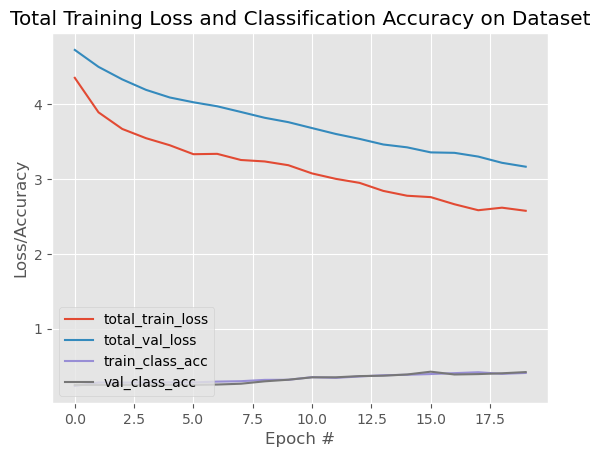

In [31]:
# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
plt.savefig(plotPath)

In [32]:
import mimetypes
import argparse
import imutils
import pickle
import torch
import cv2

In [39]:
# determine the input file type, but assume that we're working with
# single input image
# filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = ["/home/irikos/Work/datasets/coco128/images/train2017/000000000081.jpg",
              "/home/irikos/Work/datasets/coco128/images/train2017/000000000034.jpg",
              "/home/irikos/Work/datasets/coco/images/val2017/000000187144.jpg",
              "/home/irikos/Work/datasets/coco/images/val2017/000000187362.jpg",
             ] # add images


# if the file type is a text file, then we need to process *multiple*
# images
# if "text/plain" == filetype:
#     # load the image paths in our testing file
#     imagePaths = open(args["input"]).read().strip().split("\n")


In [40]:
# load our object detector, set it evaluation mode, and label
# encoder from disk
print("[INFO] loading object detector...")
model = torch.load(MODEL_PATH).to(DEVICE)
model.eval()
le = pickle.loads(open(LE_PATH, "rb").read())
# define normalization transforms
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

[INFO] loading object detector...


AttributeError: 'Compose' object has no attribute 'Compose'

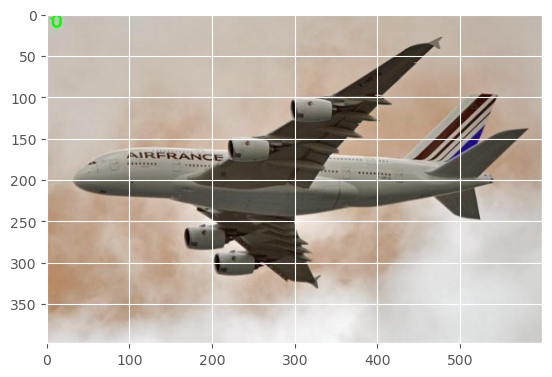

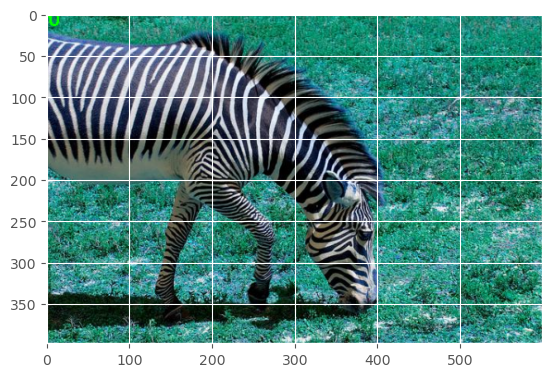

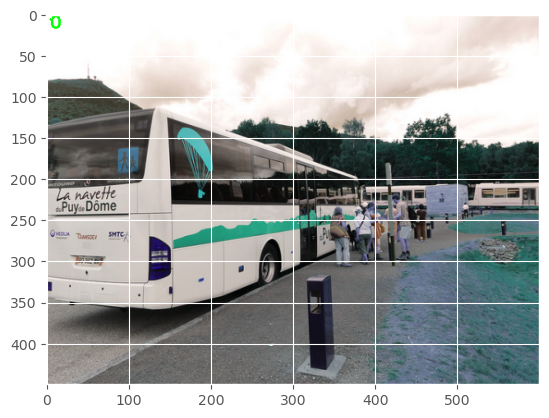

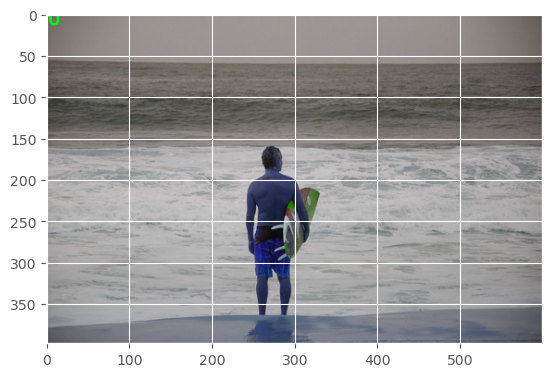

In [41]:
# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
    # load the image, copy it, swap its colors channels, resize it, and
    # bring its channel dimension forward
    image = cv2.imread(imagePath)
    orig = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.transpose((2, 0, 1))
    # convert image to PyTorch tensor, normalize it, flash it to the
    # current device, and add a batch dimension
    image = torch.from_numpy(image)
    image = transforms(image).to(DEVICE)
    image = image.unsqueeze(0)
    # predict the bounding box of the object along with the class
    # label
    (boxPreds, labelPreds) = model(image)
    (startX, startY, endX, endY) = boxPreds[0]
    # determine the class label with the largest predicted
    # probability
    labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
    i = labelPreds.argmax(dim=-1).cpu()
    label = le.inverse_transform(i)[0]
    # resize the original image such that it fits on our screen, and
    # grab its dimensions
    orig = imutils.resize(orig, width=600)
    (h, w) = orig.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    cv2.rectangle(orig, (startX, startY), (endX, endY),(0, 255, 0), 2)
    # show the output image 
#     cv2.imshow("Output", orig)
#     cv2.waitKey(0)
    h, w = orig.shape[:2]
    plt.imshow(orig)
    plt.show()